In [1]:
print("Last updated: $(read(`date`, String))")

Last updated: Mon 24 Aug 2020 10:43:44 AM PDT


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using Distances
using AbstractGPs, KernelFunctions
using PyPlot
using StatsFuns
import Random
using Flux
import LinearAlgebra
using JSON3

In [4]:
# For getting quantiles along array dimensions
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end

# To extract parameters from ADVI model.
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end
;

In [5]:
rand(GP(SEKernel())(RowVecs(randn(5, 2))))

5-element Array{Float64,1}:
 -0.5651153606165984
 -0.9658098805644102
 -0.35013925754858766
 -0.8136940978487901
  0.2956302340845827

In [6]:
# Define a kernel.
sqexpkernel(alpha::Real, rho::Real) =
    alpha^2 * transform(SEKernel(), 1/(rho*sqrt(2)))

@model GPRegression(y, X) = begin
    # Priors.
    alpha ~ LogNormal(0.0, 0.1)
    rho ~ LogNormal(0.0, 1.0)
    sigma ~ LogNormal(0.0, 1.0)
    
    # Realized covariance function
    kernel = sqexpkernel(alpha, rho)
    f = GP(kernel)
    
    # Sampling Distribution.
    # NOTE: if X is (N x D), where N=locations, D=input-dimensions, do
    # y ~ f(RowVecs(X), sigma^2 + 1e-6)
    #
    # Similarly, if X is (D x N),
    # y ~ f(ColVecs(X), sigma^2 + 1e-6)
    y ~ f(X, sigma^2 + 1e-6)  # add 1e-6 for numerical stability.
end;

In [7]:
# Read data.

# Directory where all simulation data are stored.
data_path = joinpath(@__DIR__, "../data/gp-data-N30.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), data_path)
    JSON3.read(x)
end

# Store data in (X, y) for convenience.
y = Float64.(data[:y])
X = Float64.(data[:x])

f = Float64.(data[:f])
x_grid = Float64.(data[:x_grid])

N = size(X, 1);

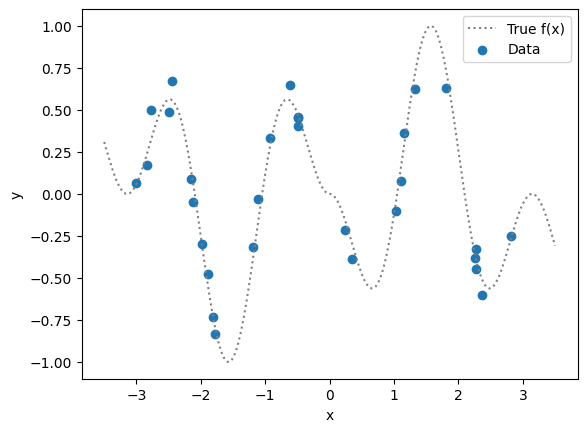

In [8]:
# Plot data
plt.scatter(X, y, label="Data")
plt.plot(x_grid, f, c="grey", ls=":", label="True f(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

In [9]:
# Create model.
m =  GPRegression(y, X);

In [10]:
# Fit via ADVI.
Random.seed!(0)

# initialize variational distribution (optional)
q0 = Variational.meanfield(m)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1), q0, optimizer=Flux.ADAM(1e-1));

# RUN
@time q = vi(m, ADVI(1, 2000), q0, optimizer=Flux.ADAM(1e-1));

# Get posterior samples
extract_gp = make_extractor(m, q)
alpha = vec(extract_gp(:alpha));
rho = vec(extract_gp(:rho));
sigma = vec(extract_gp(:sigma));
advi_samples = Dict(:alpha => alpha, :rho => rho, :sigma => sigma);

 12.618716 seconds (19.76 M allocations: 986.631 MiB, 3.44% gc time)


[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.279427 seconds (1.89 M allocations: 666.066 MiB, 5.32% gc time)


In [11]:
# Fit via HMC.
Random.seed!(0)
burn = 1000
nsamples = 1000

# Compile
@time _ = sample(m, HMC(0.01, 1), 1)

# Run
@time chain = sample(m, HMC(0.01, 100), burn + nsamples)

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[end-nsamples:end, :, 1]);
rho = vec(group(chain, :rho).value.data[end-nsamples:end, :, 1]);
sigma = vec(group(chain, :sigma).value.data[end-nsamples:end, :, 1]);
hmc_samples = Dict(:alpha => alpha, :rho => rho, :sigma => sigma);

 27.757553 seconds (43.76 M allocations: 2.134 GiB, 4.65% gc time)


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:20


 20.269593 seconds (29.11 M allocations: 29.473 GiB, 11.59% gc time)


In [12]:
# Fit via NUTS.

# Compile
Random.seed!(1)
@time _ = sample(m, NUTS(1, 0.8), 2);

# Run
Random.seed!(1)
@time chain = begin
    nsamples = 1000  # number of MCMC samples
    nadapt = 1000  # number of iterations to adapt tuning parameters in NUTS
    iterations = nsamples + nadapt
    target_accept_ratio = 0.8
    
    sample(m, NUTS(nadapt, target_accept_ratio, max_depth=10), iterations);
end

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data);
rho = vec(group(chain, :rho).value.data);
sigma = vec(group(chain, :sigma).value.data);
nuts_samples = Dict(:alpha => alpha, :rho => rho, :sigma => sigma);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/arthur/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629


 17.126661 seconds (26.22 M allocations: 1.268 GiB, 3.43% gc time)


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/arthur/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.315005 seconds (2.83 M allocations: 1.962 GiB, 12.27% gc time)


In [13]:
# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end

plot_post (generic function with 1 method)

In [14]:
function plot_fn_posterior(samples; figsize=(12, 4), figsize_f=figsize, suffix="")
    # Get parameters
    alpha = samples[:alpha]
    rho = samples[:rho]
    sigma = samples[:sigma]
    nsamps = length(alpha)
   
    # Plot parameters posterior.
    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1)
    plot_post(samples, :alpha, bins=30, suffix=suffix)
    plt.subplot(1, 3, 2)
    plot_post(samples, :rho, bins=30, suffix=suffix)
    plt.subplot(1, 3, 3)
    plot_post(samples, :sigma, bins=30, suffix=suffix)    
    plt.axvline(data[:sigma], ls=":", label="truth", color="red")
    plt.legend()
    plt.tight_layout()
    
    # Make predictions at new locations.
    # Uses AbstractGPs: GP, posterior.
    X_new = reshape(collect(range(-3.5, 3.5, length=100)), 100, 1)
    ynew = [let
        kernel = sqexpkernel(alpha[i], rho[i])
        kernel += 1e-12 * EyeKernel()  # for numerical stability.
        f = GP(kernel)
        pfx = posterior(f(X[:,1], sigma[i]^2), y)
        rand(pfx(X_new[:,1])) + randn(length(X_new)) * sigma[i]
    end for i in 1:nsamps];
    ynew = hcat(ynew...)
    
    # Summary statistics of posterior function.
    pred_mean = mean(ynew, dims=2)
    pred_lower = quantiles(ynew, 0.025, dims=2)
    pred_upper = quantiles(ynew, 0.975, dims=2)
    
    if suffix !== ""
        suffix = "($(suffix))"
    end 
     
    # Plot predictions.
    plt.figure(figsize=figsize_f)
    plt.plot(vec(X_new), vec(pred_mean), color="blue", label="Posterior predictive mean")
    plt.plot(x_grid, f, color="red", ls=":", label="True f(x)")
    
    plt.scatter(vec(X), vec(y), color="black", label="Data")
    plt.fill_between(vec(X_new), vec(pred_upper), vec(pred_lower), color="blue",
                     alpha=0.2, label="95% Credible Interval")
    plt.legend(loc="upper left", fontsize=8)
    plt.title("GP Posterior predictive with 95% credible interval $(suffix)");
    
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.ylim(-2, 2)
    plt.tight_layout()
end

plot_fn_posterior (generic function with 1 method)

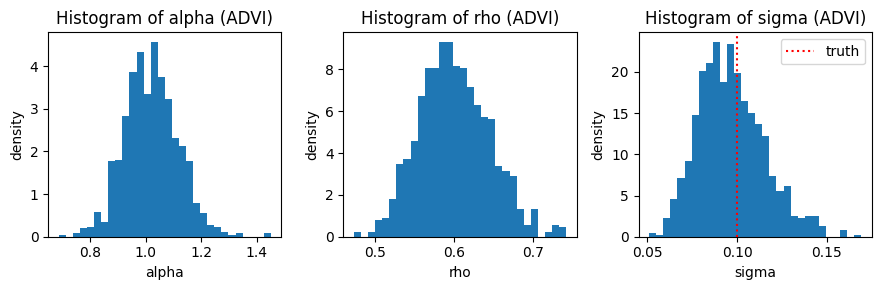

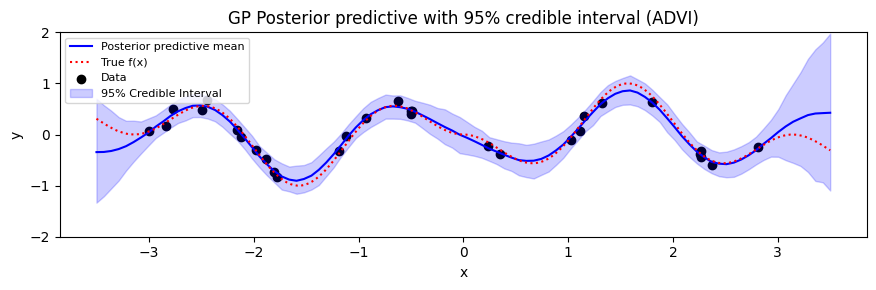

In [15]:
plot_fn_posterior(advi_samples, figsize=(9, 3), suffix="ADVI")

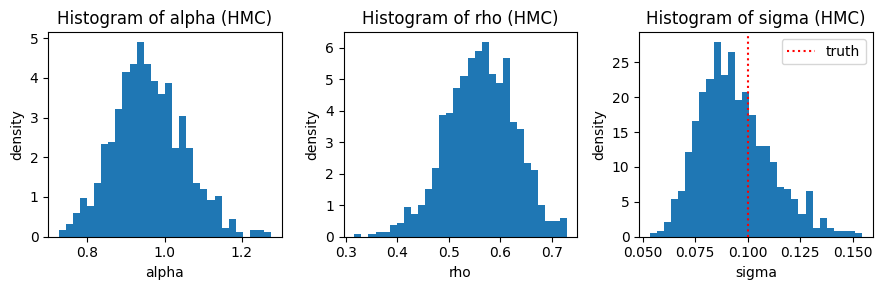

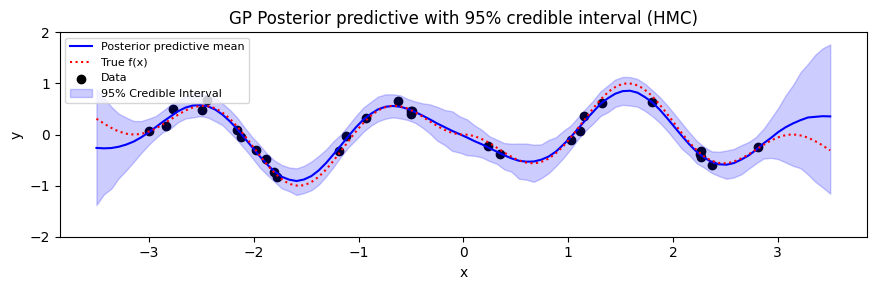

In [16]:
plot_fn_posterior(hmc_samples, figsize=(9, 3), suffix="HMC");

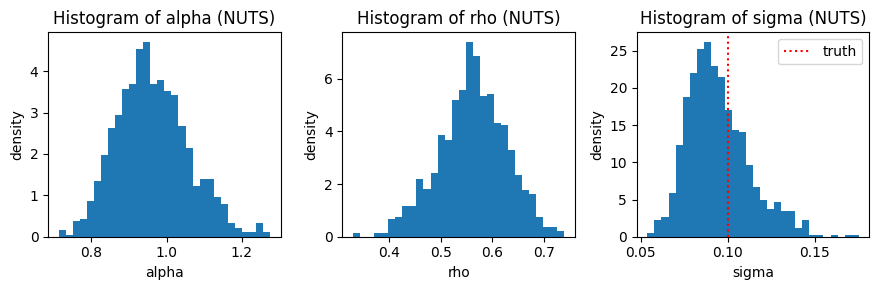

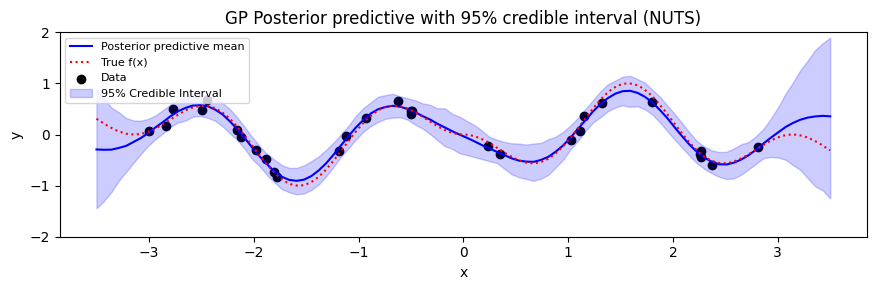

In [17]:
plot_fn_posterior(nuts_samples, figsize=(9, 3), suffix="NUTS");